In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

In [3]:
# 학습 데이터 데이터 증진(data augmentation)
transform_train = transforms.Compose([
    # [예상] class 부위가 작기 때문에 현재의 training data augmentation이 너무 단조로울 것 같다.
    # * 현재는 단순히 사이즈를 (256, 256)으로 맞추고 좌우 반전하는 게 끝이므로,
    # * 사실상 데이터가 100개라면, 최대 200개가 있는 것 정도로 끝인 셈이다.
    #   * 그래서 너무 금방 training data fitting이 발생할 수 있다.
    # * 따라서 Centor Cropping 혹은 Random Resized Cropping을 학습에 사용하면 도움이 될 것 같다.
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.5, 1.0), ratio=(3 / 4, 4 / 3)),
    transforms.Resize((256, 256)), # 데이터의 크기를 동일하게 맞춰주기
    transforms.RandomHorizontalFlip(), # 데이터 증진
    transforms.ToTensor(), # 각 픽셀의 값을 [0, 1]
    # R, G, B 각각에 대하여 픽셀 평균 값을 0, 표준 편차를 1로
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# [의문점] 만약 Random Resized Cropping을 사용하면, 가끔은 아예 class가 없는 부분 등장 가능하다.
# * 악영향을 미칠 수도 있지만, epoch 수가 충분히 많은 경우에는 오히려 일반화 성능이 향상될 수 있음
#   * 모델이 헷갈린다고 해서 무조건 안 좋은 게 아닐 수 있다.
#   * class없는 부분을 줬을 때, 정답이 바뀔 수 있다는 점 → 모델의 over-confident를 막게 될 여지도 있다.

# 검증과 테스트 데이터 세트에서는 데이터 증진을 하지 않습니다.
# "확률적인 요소"가 가미된 내용은 검증 및 테스트에서 사용하지 X
#   TTA 테스트 시기 때 augmentation을 할 수도 있긴 한데, 이 경우에도 랜덤성은 없도록 해요.
#   TTA (Test-Time Augmentation): 보통 object detection에서 많이 사용됨.
#    - 하나의 size로만 모델의 결과를 내는 게 아니라, 여러 크기에 대해서 결과 낸 뒤에 앙상블
transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [4]:
# 데이터 세트 객체는 이거 한 줄로 끝
# ImageFolder는 아래와 같은 구성이면 자동으로 불러옴.
"""
dataset/
  class_0/
    0.png
    1.png
    ...
  class_1/
    0.png
    1.png
    ...
  ...
"""
train_dataset = datasets.ImageFolder(
    root='/content/drive/MyDrive/dataset/train',
    transform=transform_train
)

dataset_size = len(train_dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(
    root='/content/drive/MyDrive/dataset/test',
    transform=transform_test
)

# shuffle을 학습 데이터에 대해서만 수행
# 모델에게 "등장하는(보여지는)" 이미지의 순서를 랜덤성 있게 바꾸어주기 위해
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

torch.Size([3, 260, 1550])


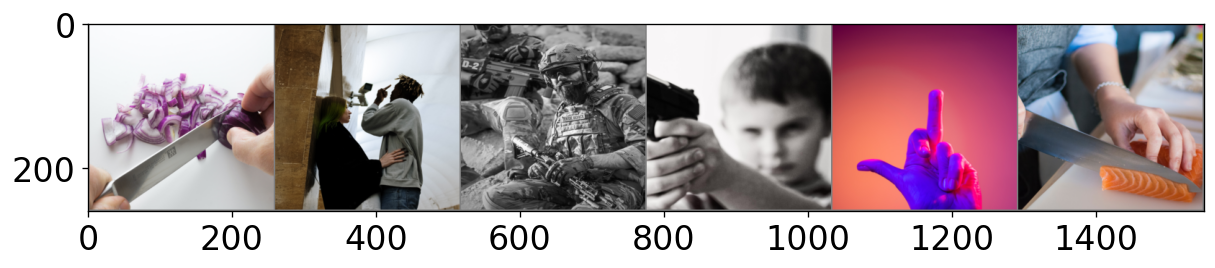

['Knife', 'Bad fingers', 'Gun', 'Gun', 'Bad fingers', 'Knife']


In [6]:
# matplotlib의 기본 설정을 바꿔줄 수 있음
# 이미지 크기(figure size = figsize)
# dpi가 해상도 => 얘가 높아지면 고해상도
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 120 # 원래 60에서 -> 2배
plt.rcParams.update({'font.size': 20})


# 어떤 tensor 객체가 있을 때, 얘를 시각화하는 함수
# tensor => numpy로 바꾸기
# 바뀐 데이터는 R, G, B 각각에 대해서 평균이 0이고 표준 편차가 1로 되어 있음
# 다시 돌려주기 위해, 표준 편차 곱해주고 평균을 더해주면 됨.
# 원래 정규화 공식: Y = (X - mu / std)
# 돌려주려면 Y * std + mu = X
# 그냥 공식 그대로 넣은 것.
def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    # 혹시나 0과 1을 벗어나는 픽셀 값이 있는 경우
    # (precision 때문에 발생 가능) [0, 1] 사이의 값이 되도록 벗어나는  값은 clipping
    # 예시) 1.05인 경우 1이 됩니다.
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.show()


class_names = {
  0: "Alcohol",
  1: "Bad fingers",
  2: "Blood",
  3: "Cigarette",
  4: "Gun",
  5: "Knife"
}

# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
imgs, labels = next(iterator)
# torchvision.utils.make_grid는 tensor를 넣어주면
# 이미지인 경우 [batch_size, channel, width, height]에 대하여
# 이 크기에 맞게 자동으로 격자 형태로 하나의 tensor를 만들어 줌.
# [channel, width, height]의 형태를 가짐
out = torchvision.utils.make_grid(imgs[:6])
print(out.shape)
imshow(out)
print([class_names[labels[i].item()] for i in range(6)])

In [7]:
learning_rate = 0.001
log_step = 20
n_classes = 6

# PyTorch에서 기본적으로 제공하고 있는 ResNet50 아키텍처를 그대로 사용
# PyTorch에서는 기본적으로 "ImageNet 데이터 세트"에 한 번 학습된 모델을 제공
# 그게 바로 pretrained=True를 설정하면 됨.
model = models.resnet50(pretrained=True)

# 앞쪽에 있는 feature extractor 레이어는 그대로 사용하되
# 마지막에 있는 "FC 레이어 하나만" 우리가 새로 "처음부터" 학습
# 앞쪽 레이어는 가져다 쓰되, fine-tuning (가중치를 조금만 변경)
num_features = model.fc.in_features
# (중요) 마지막 레이어만 새롭게 교체
model.fc = nn.Linear(num_features, n_classes) # transfer learning
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 318MB/s]


In [8]:
import time


def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [9]:
import time

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 5:
        lr /= 10
    if epoch >= 10:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}.pth')

torch.save(model.state_dict(), f'last_checkpoint.pth')

[Epoch: 1 - Training]
train loss: 0.22240659180614683, accuracy: 0.2152777761220932
elapsed time: 169.26575803756714
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.22174271941184998, running val accuracy: 0.375
val loss: 0.2286015682750278, accuracy: 0.472222238779068
elapsed time: 45.89672803878784
[Info] best validation accuracy!
[Epoch: 2 - Training]
train loss: 0.17206662024060884, accuracy: 0.5208333134651184
elapsed time: 61.890531063079834
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.06558012217283249, running val accuracy: 1.0
val loss: 0.13140844139787886, accuracy: 0.7222222089767456
elapsed time: 13.983369588851929
[Info] best validation accuracy!
[Epoch: 3 - Training]
train loss: 0.11866193347507054, accuracy: 0.6805555820465088
elapsed time: 59.58971548080444
[Epoch: 3 - Validation]
[Batch: 1] running val loss: 0.02630065381526947, running val accuracy: 1.0
val loss: 0.0753410988383823, accuracy: 0.8888888955116272
elapsed time: 13.728634119033813
[Info] 

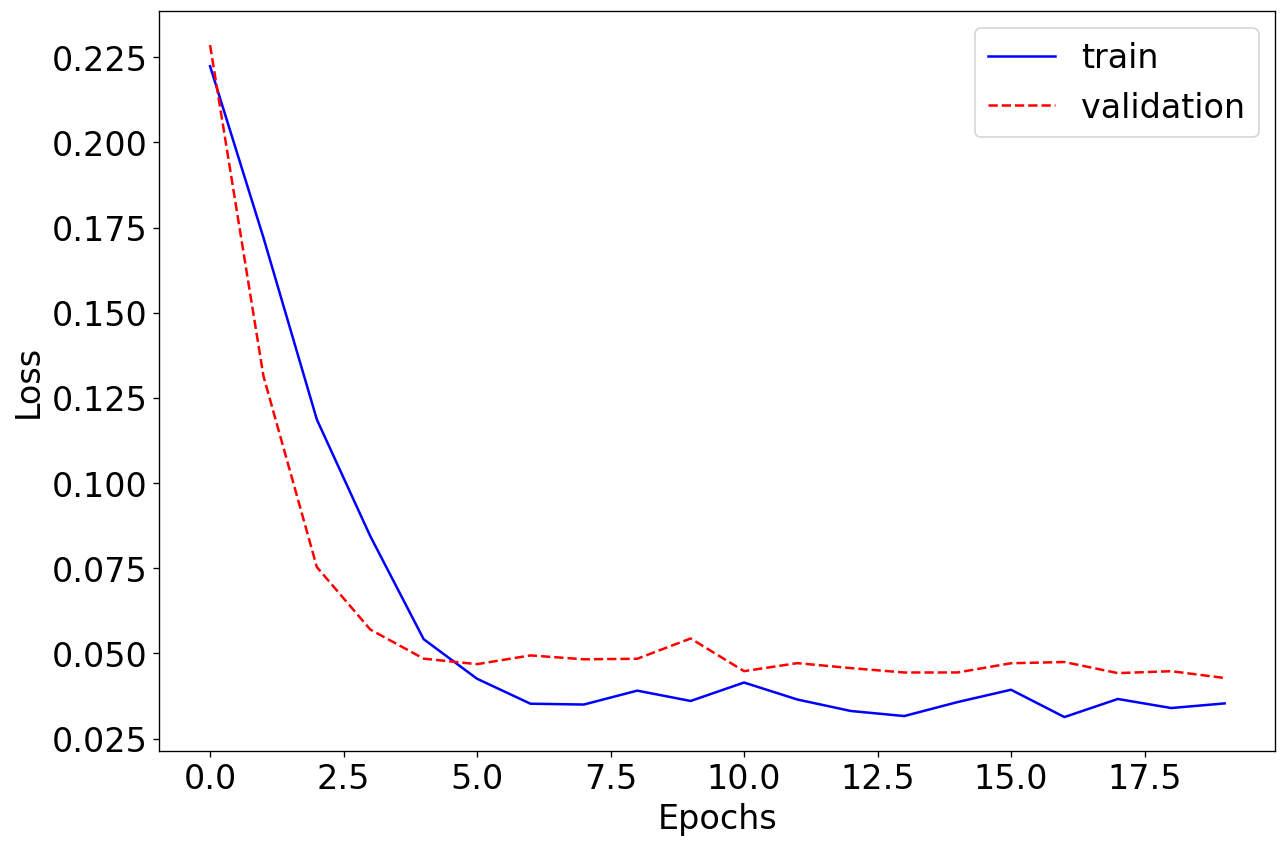

In [10]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

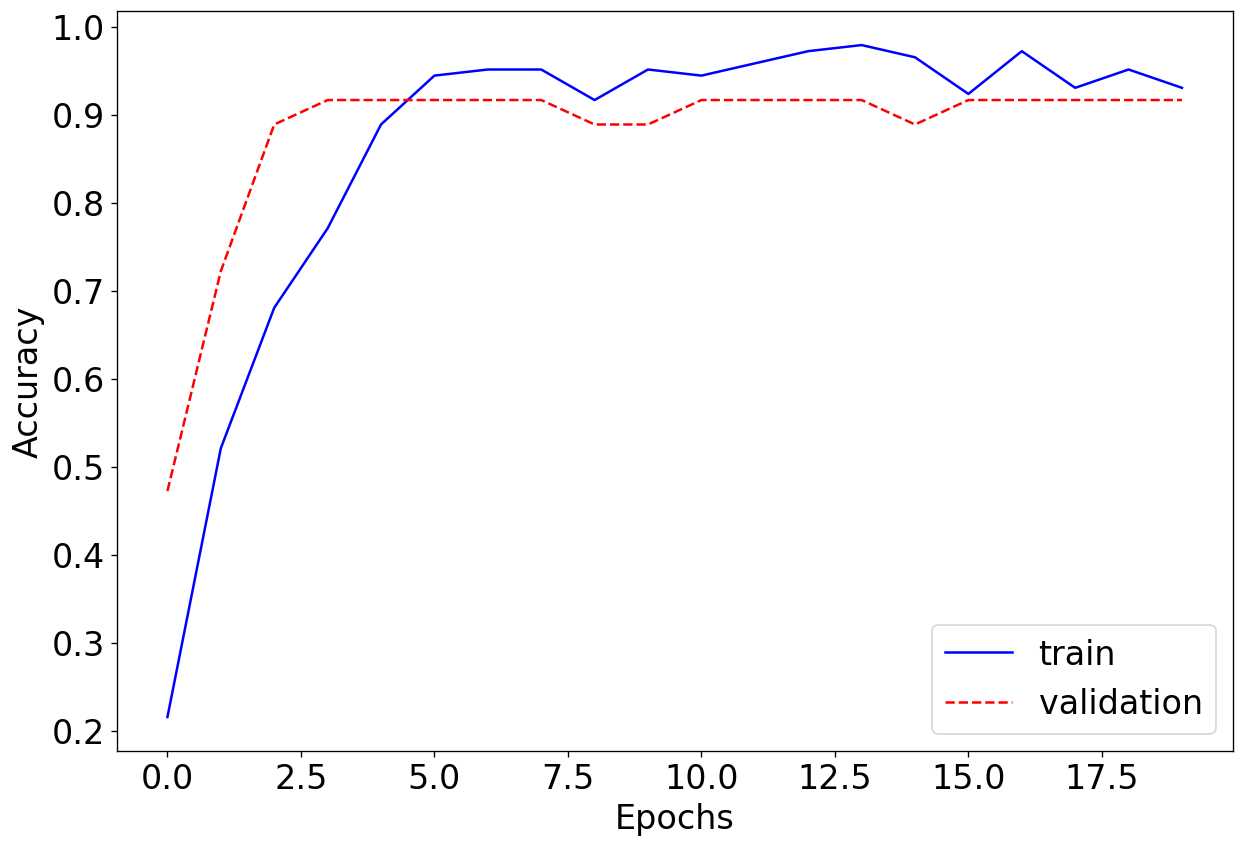

In [11]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [12]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6) # transfer learning
model = model.cuda()
model_path = 'last_checkpoint.pth'
model.load_state_dict(torch.load(model_path))

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch: 1] running test loss: 0.007029149681329727, running test accuracy: 1.0
test loss: 0.09732659558455149, accuracy: 0.7000000476837158
elapsed time: 70.12102222442627
Test loss: 0.09732660
Test accuracy: 70.00%


In [17]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6) # transfer learning
model = model.cuda()
model_path = f"best_checkpoint_epoch_4.pth"
model.load_state_dict(torch.load(model_path))

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch: 1] running test loss: 0.018583869561553, running test accuracy: 1.0
test loss: 0.11204173937439918, accuracy: 0.7166666984558105
elapsed time: 24.40027642250061
Test loss: 0.11204174
Test accuracy: 71.67%
